# Forward Curves
This examples shows 
1. Generating an Access Token and using it in API Calls.
2. Calling the `market-data/reference-date/v3/forward-curve/search` endpoint to find a particular curve.
3. Calling the `market-data/forward-curve/v3/curve-code` endpoint to get assessments for a specific `curve_code`.
4. Converting response into a DataFrame.
5. Charting the Forward Curve.

## Fetching Data

### Install Dependencies
```python
pip install requests pandas matplotlib
```

Import dependencies

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

Set `username`, `password`, and `apikey` here for simplicity

In [2]:
username = "USERNAME"
password = "PASSWORD"
apikey = "APIKEY"

```{seealso}
This `get_token` function is taken from [Generating a Token](../token.ipynb)
```

In [3]:
def get_token(username, password, apikey):
  """Get an Access Token to make API calls with."""
  body = {
    "username": username,
    "password": password
  }
  headers = {
    "appkey": apikey
  }
  try:
    r = requests.post("https://api.platts.com/auth/api", data=body, headers=headers)
    r.raise_for_status()
    return r.json()["access_token"]
  except Exception as err:
    if r.status_code >= 500:
      print(err)
    else:
      print(r.status_code, r.json())

### Search Curves
1. Create a function - `search_curves` - to call the Forward Curves Search endpoint.
2. Requires `username`, `password`, `apikey` and a search term - `q`.
3. Returns a `dict` (json) of the data.

In [4]:
def search_curves(username, password, apikey, q):
  """Search for curves based on `q`"""
  token = get_token(username, password, apikey)
  headers= {
    "appkey": apikey,
    "Authorization": f"Bearer {token}"
  }

  params = {
    "q": q
  }

  try:
    r = requests.get("https://api.platts.com/market-data/reference-data/v3/forward-curve/search", headers=headers, params=params)
    r.raise_for_status()
    return r.json()
  except Exception as err:
    if r.status_code >= 500:
      print(err)
    else:
      print(r.status_code, r.json())
    raise

Invoke `search_curves` and print results

In [5]:
data = search_curves(username, password, apikey, "Copper")
data['results'][:2]

[{'commodity': 'Copper',
  'contract_type': 'Future',
  'currency': 'CNY',
  'curve_code': 'CN2UN',
  'curve_name': 'SHFE Copper Floor Abs Futures',
  'curve_type': 'Absolute Forward Curve',
  'delivery_region': 'Shanghai',
  'holiday_schedule': 'CALSF00',
  'mdc': ['MX'],
  'mdc_description': ['Metals: Misc Non-Platts Data - Non-Ferrous'],
  'uom': 'TON'},
 {'commodity': 'Copper',
  'contract_type': 'Future',
  'currency': 'CNY',
  'curve_code': 'CN2UM',
  'curve_name': 'SHFE Copper Close Abs Futures',
  'curve_type': 'Absolute Forward Curve',
  'delivery_region': 'Shanghai',
  'holiday_schedule': 'CALSF00',
  'mdc': ['MX'],
  'mdc_description': ['Metals: Misc Non-Platts Data - Non-Ferrous'],
  'uom': 'TON'}]

### Get Curve by Curve Code
1. Create a function - `get_curve_by_curvecode` - to call the Forward Curves Curve Code endpoint.
2. Requires `username`, `password`, `apikey` and a `curve_code`.
3. Returns a `dict` (json) of the data.

In [6]:
def get_curve_by_curvecode(username, password, apikey, curve_code):
  """fetch assessments for a specific curve"""
  token = get_token(username, password, apikey)
  headers= {
    "appkey": apikey,
    "Authorization": f"Bearer {token}"
  }

  params = {
    "filter": f'curve_code: "{curve_code}"'
  }

  try:
    r = requests.get("https://api.platts.com/market-data/forward-curve/v3/curve-code", headers=headers, params=params)
    r.raise_for_status()
    return r.json()
  except Exception as err:
    if r.status_code >= 500:
      print(err)
    else:
      print(r.status_code, r.json())
    raise

Invoke `get_curve_by_curvecode` and print a subset of results.

In [7]:
curve_data = get_curve_by_curvecode(username, password, apikey, "CN2UN")
curve_data['results']['symbol_data'][:2]

[{'symbol': 'XHCUN22',
  'contract_label': 'JUL 2022',
  'derivative_maturity_frequency': 'Month',
  'derivative_position': 1,
  'notional_contract': 'July 2022',
  'data': [{'bate': 'w', 'assessDate': '2022-06-20T00:00:00', 'value': 116285},
   {'bate': 'o', 'assessDate': '2022-06-20T00:00:00', 'value': 69450},
   {'bate': 'h', 'assessDate': '2022-06-20T00:00:00', 'value': 69450},
   {'bate': 'c', 'assessDate': '2022-06-20T00:00:00', 'value': 68670},
   {'bate': 'e', 'assessDate': '2022-06-20T00:00:00', 'value': 125733},
   {'bate': 'l', 'assessDate': '2022-06-20T00:00:00', 'value': 68000}]},
 {'symbol': 'XHCUQ22',
  'contract_label': 'AUG 2022',
  'derivative_maturity_frequency': 'Month',
  'derivative_position': 2,
  'notional_contract': 'August 2022',
  'data': [{'bate': 'h', 'assessDate': '2022-06-20T00:00:00', 'value': 69230},
   {'bate': 'o', 'assessDate': '2022-06-20T00:00:00', 'value': 69230},
   {'bate': 'l', 'assessDate': '2022-06-20T00:00:00', 'value': 67700},
   {'bate': '

## Using Pandas
[ Pandas ]( https://pandas.pydata.org/ ) is one of the best tools for data anlysis in Python and converting our data into a Data Frame is necessary in order to use it so let's do that now.

### Creating a DataFrame
Flattening our JSON response into a DataFrame.

In [17]:
df = pd.json_normalize(curve_data['results'], record_path=["symbol_data", "data"], 
  meta=['curve_name', 'curve_code', ['symbol_data', 'symbol'], ['symbol_data', 'derivative_position'], 
    ['symbol_data', 'contract_label'], ['symbol_data', 'derivative_maturity_frequency']])
df.columns = df.columns.str.replace("symbol_data.", "", regex=True)
df.style.set_table_attributes('style="font-size: 10px"')
df.head(5)

,bate,assessDate,value,curve_name,curve_code,symbol,derivative_position,contract_label,derivative_maturity_frequency
0,w,2022-06-20T00:00:00,116285,SHFE Copper Floor Abs Futures,CN2UN,XHCUN22,1,JUL 2022,Month
1,o,2022-06-20T00:00:00,69450,SHFE Copper Floor Abs Futures,CN2UN,XHCUN22,1,JUL 2022,Month
2,h,2022-06-20T00:00:00,69450,SHFE Copper Floor Abs Futures,CN2UN,XHCUN22,1,JUL 2022,Month
3,c,2022-06-20T00:00:00,68670,SHFE Copper Floor Abs Futures,CN2UN,XHCUN22,1,JUL 2022,Month
4,e,2022-06-20T00:00:00,125733,SHFE Copper Floor Abs Futures,CN2UN,XHCUN22,1,JUL 2022,Month


### Data Adjustments
1. Filter to only `c` (Close) and Monthly curves.
2. Set the index to the `contract_label` field, but converted to a Pandas `PeriodIndex` so that we can do Date/Time operations on it.

In [15]:
filt = df['derivative_maturity_frequency'] == "Month"
filt2 = df['bate'] == "c"
chart_df = df[filt & filt2]
chart_df = chart_df.set_index(pd.PeriodIndex(chart_df['contract_label'], freq="M"))

### Plotting the Curve
Use [Matplotlib](https://matplotlib.org/) to visualize the curve.


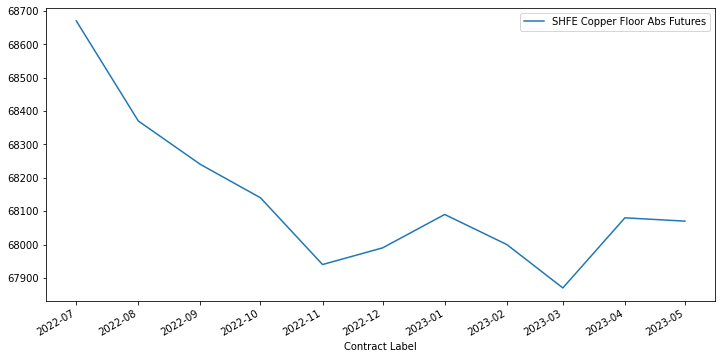

In [10]:
fig, ax = plt.subplots()
chart_df['value'].plot(ax=ax, figsize=(12,6), x_compat=True, label=chart_df['curve_name'][0])
ax.set_xlabel("Contract Label")
ax.legend();